In [1]:
pip install pandas numpy scikit-learn tensorflow matplotlib seaborn openpyxl pyyaml

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


[INFO] Loaded Maths.csv as Excel (openpyxl), shape=(397, 33)
[INFO] Loaded Portuguese.csv as Excel (openpyxl), shape=(651, 33)
[INFO] Loaded 2012-2013-data-with-predictions-4-final.csv as CSV enc='utf-8', sep=',', shape=(6123270, 35)
[INFO] Combined shape: (1048, 33)
[INFO] #categorical=17, #numeric=13
[INFO] Saved preprocessor.pkl and label_encoder.pkl
Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7196 - loss: 0.6060 - val_accuracy: 0.7321 - val_loss: 0.5927
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7661 - loss: 0.5212 - val_accuracy: 0.7440 - val_loss: 0.5380
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7923 - loss: 0.4541 - val_accuracy: 0.7500 - val_loss: 0.5370
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8192 - loss: 0.4289 - val_accuracy: 0.7560 - val_loss: 0.5435
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8383 - loss: 0.3897 - val_accuracy: 0.7619 - val_loss: 0.5213
Epoch 6/

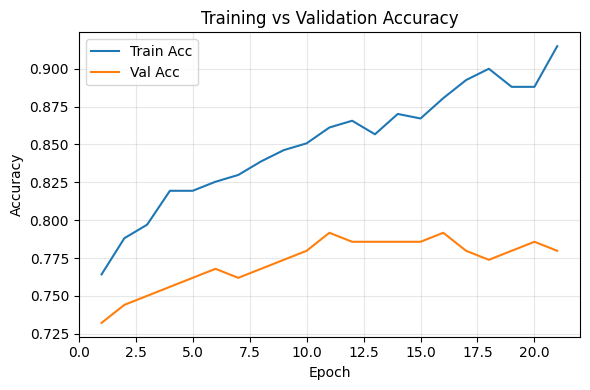

[INFO] Saved accuracy_plot.png -> C:\Users\sagni\Downloads\Dynamic Curriculum Designer\accuracy_plot.png
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

=== Test Accuracy: 0.8

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.59      0.28      0.38        46
           1       0.82      0.95      0.88       164

    accuracy                           0.80       210
   macro avg       0.71      0.61      0.63       210
weighted avg       0.77      0.80      0.77       210



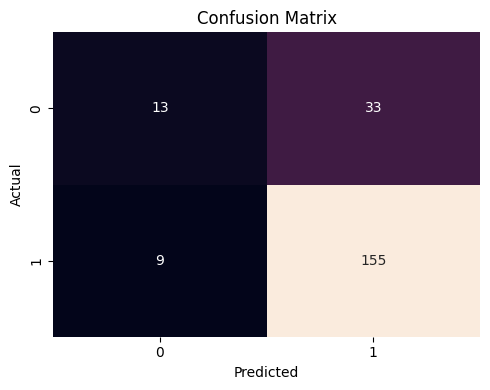

[INFO] Saved confusion_matrix.png -> C:\Users\sagni\Downloads\Dynamic Curriculum Designer\confusion_matrix.png
[INFO] Saved model.h5 -> C:\Users\sagni\Downloads\Dynamic Curriculum Designer\model.h5
[INFO] Saved model_config.yaml -> C:\Users\sagni\Downloads\Dynamic Curriculum Designer\model_config.yaml


In [2]:
# ==============================================
# Dynamic Curriculum Designer: Excel-safe loader + Full pipeline
# Saves: preprocessor.pkl, label_encoder.pkl, model.h5, model_config.yaml (or .json),
#        accuracy_plot.png, confusion_matrix.png
# ==============================================

import os, io, csv, warnings, json, pickle, zipfile
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ---------- Paths you provided ----------
DATA_MATHS = r"C:\Users\sagni\Downloads\Dynamic Curriculum Designer\archive (1)\Maths.csv"
DATA_PORT  = r"C:\Users\sagni\Downloads\Dynamic Curriculum Designer\archive (1)\Portuguese.csv"
# Optional dataset (not used in this baseline):
DATA_ASSIST = r"C:\Users\sagni\Downloads\Dynamic Curriculum Designer\archive (2)\2012-2013-data-with-predictions-4-final.csv"

OUTPUT_DIR = r"C:\Users\sagni\Downloads\Dynamic Curriculum Designer"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------- Helper: detect if file is actually an Excel/ZIP ----------
def is_zip_or_xlsx(path):
    try:
        with open(path, "rb") as f:
            sig = f.read(2)
        return sig == b"PK"  # XLSX is a zipped XML; starts with 'PK'
    except Exception:
        return False

# ---------- Robust reader: Excel if PK header, else CSV with encoding+sep tries ----------
def robust_read_any(path, name_hint=""):
    if not os.path.exists(path):
        print(f"[ERROR] File not found: {path}")
        return None

    if is_zip_or_xlsx(path):
        # Treat as Excel (even if extension is .csv)
        try:
            df = pd.read_excel(path, engine="openpyxl")
            print(f"[INFO] Loaded {os.path.basename(path)} as Excel (openpyxl), shape={df.shape}")
            return df
        except Exception as e:
            print(f"[WARN] Excel read failed for {path}: {e}")

    # Try CSV paths (encoding + delimiter variations)
    encodings = ["utf-8", "utf-8-sig", "cp1252", "latin1"]
    delimiters = [";", ",", "\t", "|"]

    # Attempt to sniff delimiter using a latin1 decode to avoid decode errors
    try:
        with open(path, "rb") as f:
            head = f.read(4096).decode("latin1", errors="ignore")
        try:
            sniffer = csv.Sniffer()
            sniffed = sniffer.sniff(head)
            primary_delim = sniffed.delimiter
            if primary_delim in delimiters:
                delimiters = [primary_delim] + [d for d in delimiters if d != primary_delim]
        except Exception:
            pass
    except Exception:
        pass

    last_err = None
    for enc in encodings:
        for sep in delimiters:
            try:
                df = pd.read_csv(path, encoding=enc, sep=sep, engine="python")
                if df.shape[1] > 1:  # avoid false positives where entire row becomes one column
                    print(f"[INFO] Loaded {os.path.basename(path)} as CSV enc='{enc}', sep='{sep}', shape={df.shape}")
                    return df
            except Exception as e:
                last_err = e
                continue
    print(f"[ERROR] Could not read {path}. Last error: {last_err}")
    return None

# ---------- Load your datasets ----------
df_m = robust_read_any(DATA_MATHS, "Maths")
df_p = robust_read_any(DATA_PORT, "Portuguese")
# optional:
_ = robust_read_any(DATA_ASSIST, "Assistments")  # just to show it loads; not used below

if df_m is None or df_p is None:
    raise FileNotFoundError("Failed to load Maths/Portuguese datasets after robust attempts.")

# ---------- Harmonize & combine on common columns ----------
common_cols = sorted(set(df_m.columns).intersection(set(df_p.columns)))
if not common_cols:
    raise ValueError("No common columns found between Maths and Portuguese datasets.")
df = pd.concat([df_m[common_cols], df_p[common_cols]], ignore_index=True)
print("[INFO] Combined shape:", df.shape)

# ---------- Target: PASS if G3 >= 10; drop G1/G2/G3 to avoid leakage ----------
if "G3" not in df.columns:
    raise ValueError("Column 'G3' not found after loading. Check that the sheets/tables are correct.")

df = df.dropna(subset=["G3"]).copy()
df["target"] = (pd.to_numeric(df["G3"], errors="coerce") >= 10).astype(int)

for c in ["G1", "G2", "G3"]:
    if c in df.columns:
        df.drop(columns=[c], inplace=True)

# ---------- Feature typing ----------
cat_cols = [c for c in df.columns if df[c].dtype == "object" and c != "target"]
num_cols = [c for c in df.columns if c not in cat_cols + ["target"]]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Simple cleanup; you can replace this with imputation if desired
df = df.dropna(subset=num_cols)

print(f"[INFO] #categorical={len(cat_cols)}, #numeric={len(num_cols)}")

X = df[cat_cols + num_cols]
y = df["target"].astype(int).values

# ---------- Label encoding of target ----------
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# ---------- Preprocessor ----------
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop"
)

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

# Save preprocessor + label encoder
with open(os.path.join(OUTPUT_DIR, "preprocessor.pkl"), "wb") as f:
    pickle.dump(preprocessor, f)
with open(os.path.join(OUTPUT_DIR, "label_encoder.pkl"), "wb") as f:
    pickle.dump(le, f)
print("[INFO] Saved preprocessor.pkl and label_encoder.pkl")

# ---------- Build & train model ----------
def build_model(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

model = build_model(X_train_proc.shape[1])

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", mode="max", patience=10, restore_best_weights=True
)

history = model.fit(
    X_train_proc, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# ---------- Accuracy graph (train vs val) ----------
hist = history.history
epochs_ran = range(1, len(hist["accuracy"]) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs_ran, hist["accuracy"], label="Train Acc")
plt.plot(epochs_ran, hist["val_accuracy"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
acc_plot_path = os.path.join(OUTPUT_DIR, "accuracy_plot.png")
plt.tight_layout()
plt.savefig(acc_plot_path, dpi=150)
plt.show()
print(f"[INFO] Saved accuracy_plot.png -> {acc_plot_path}")

# ---------- Evaluate + confusion matrix ----------
y_pred_prob = model.predict(X_test_proc).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
print("\n=== Test Accuracy:", round(acc, 4))
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=[str(c) for c in le.classes_]))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
cm_path = os.path.join(OUTPUT_DIR, "confusion_matrix.png")
plt.tight_layout()
plt.savefig(cm_path, dpi=150)
plt.show()
print(f"[INFO] Saved confusion_matrix.png -> {cm_path}")

# ---------- Save model (.h5) ----------
h5_path = os.path.join(OUTPUT_DIR, "model.h5")
model.save(h5_path)
print(f"[INFO] Saved model.h5 -> {h5_path}")

# ---------- Save model config as YAML (fallback JSON) ----------
saved_yaml = False
try:
    import yaml
    cfg = model.get_config()
    with open(os.path.join(OUTPUT_DIR, "model_config.yaml"), "w", encoding="utf-8") as f:
        yaml.safe_dump(cfg, f, sort_keys=False)
    print(f"[INFO] Saved model_config.yaml -> {os.path.join(OUTPUT_DIR, 'model_config.yaml')}")
    saved_yaml = True
except Exception as e:
    print("[WARN] Could not write YAML (install pyyaml). Saving JSON instead:", e)

if not saved_yaml:
    with open(os.path.join(OUTPUT_DIR, "model_config.json"), "w", encoding="utf-8") as f:
        json.dump(model.get_config(), f, indent=2)
    print(f"[INFO] Saved model_config.json -> {os.path.join(OUTPUT_DIR, 'model_config.json')}")

# ---------- User-input prediction helper ----------
def predict_from_dict(feature_dict, model_path=os.path.join(OUTPUT_DIR, "model.h5")):
    """
    feature_dict: {column_name: value, ...} using ORIGINAL column names (cat_cols + num_cols).
    Unknown categories are ignored (OneHotEncoder handle_unknown='ignore').
    """
    expected_cols = cat_cols + num_cols
    row = {col: feature_dict.get(col, np.nan) for col in expected_cols}
    X_new = pd.DataFrame([row], columns=expected_cols)

    with open(os.path.join(OUTPUT_DIR, "preprocessor.pkl"), "rb") as f:
        preproc = pickle.load(f)
    with open(os.path.join(OUTPUT_DIR, "label_encoder.pkl"), "rb") as f:
        lab = pickle.load(f)

    X_new_proc = preproc.transform(X_new)
    mdl = keras.models.load_model(model_path)
    prob = float(mdl.predict(X_new_proc).ravel()[0])
    pred = int(prob >= 0.5)
    label = lab.inverse_transform([pred])[0]
    return {"probability_pass": prob, "predicted_class": pred, "label_decoded": str(label)}

# # Quick test (uncomment & adjust values to your columns)
# example = {
#     "school":"GP","sex":"F","address":"U","famsize":"GT3","Pstatus":"T",
#     "schoolsup":"no","famsup":"yes","paid":"no","activities":"yes","nursery":"yes","higher":"yes","internet":"yes","romantic":"no",
#     "age":17,"Medu":3,"Fedu":2,"traveltime":1,"studytime":2,"failures":0,"famrel":4,"freetime":3,"goout":3,"Dalc":1,"Walc":1,"health":5,"absences":4
# }
# print(predict_from_dict(example))
